# Drug consumption prediction with a RNN

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

import tensorflow as tf
import matplotlib as mpl
from sklearn.model_selection import train_test_split

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

print(tf.__version__)
#tf.random.set_seed(42)

2.2.0-dev20200506


___
## Data preparation

In [2]:
# Read CSVs
PatientConsumption = pd.read_csv('PatientConsumption 2018-2019.csv').drop_duplicates()
PurchasedOrders    = pd.read_csv('PurchasedOrders 2018-2019.csv').drop_duplicates()
IncompleteOrders   = pd.read_csv('IncompleteOrders 2018-2019.csv').drop_duplicates()
PatentDrugs        = pd.read_csv('Diccionario_v3.csv').drop_duplicates()
# Values to predict
PatientConsumption2020 = pd.read_csv('PatientConsumption 2020.csv').drop_duplicates()

# Retrieve date columns and apply to_datetime, set amount columns as numeric
date_columns   = [column for column in PatientConsumption.columns if 'Date' in column]
amount_columns = [column for column in PatientConsumption.keys() if 'Amount' in column]
PatientConsumption[date_columns]   = PatientConsumption[date_columns].apply(pd.to_datetime)
PatientConsumption[amount_columns] = PatientConsumption[amount_columns].astype(int)
# Values to predict
PatientConsumption2020[date_columns]   = PatientConsumption2020[date_columns].apply(pd.to_datetime)
PatientConsumption2020[amount_columns] = PatientConsumption2020[amount_columns].astype(int)

date_columns   = [column for column in PurchasedOrders.columns if 'Date' in column]
amount_columns = [column for column in PurchasedOrders.keys() if 'Amount' in column]
PurchasedOrders[date_columns]   = PurchasedOrders[date_columns].apply(pd.to_datetime)
PurchasedOrders[amount_columns] = PurchasedOrders[amount_columns].astype(int)

date_columns   = [column for column in IncompleteOrders.columns if 'Date' in column]
amount_columns = [column for column in IncompleteOrders.keys() if 'Amount' in column]
IncompleteOrders[date_columns]   = IncompleteOrders[date_columns].apply(pd.to_datetime)
IncompleteOrders[amount_columns] = IncompleteOrders[amount_columns].astype(int)

___
## Visualize time series for drugs of interest
This section follows the same sequence as the Visualization of the Top 9 drugs section in the EDA.

In [3]:
# Define our top 9 drugs (see EDA.ipynb)
TopMeds=['COMBIVENT 0.5/2.5MG AMPOLLETA 2.5ML (IPRATROPIO/ SALBUTAMOL)',
        'FIRAC PLUS 100MG AMP (CLONIXINATO LISINA/PARGEVER)',
        'FLIXOTIDE 2MG AMP 2ML (FLUTICASONA)',
        'SOMAZINA 1G AMP 4ML (CITICOLINA)',
        'INDAFLEX 2.5% CREMA 40G TUBO(INDOMETACINA)',
        'MYDOCALM A C/30 CAPS TOLPERISONA /PARACETAMOL',
        'VANCOCIN CP 1G AMP (VANCOMICINA)',
        'COMBIVENT RESPIMAT 1.68/8.77MG C/DOSIF.(IPRATRO./ SALBUTAMOL',
        'LIPITOR 80MG C/30 TAB(ATORVASTATINA)']

TopMedCodes = PatentDrugs[PatentDrugs['MedDescription'].isin(TopMeds)]['MedCode']
PatentDrugs[PatentDrugs['MedDescription'].isin(TopMeds)]

,MedCode,MedDescription,Compound,MedFamily,MedPriceMXN,MinStock,MaxStock
14,3300115,INDAFLEX 2.5% CREMA 40G TUBO(INDOMETACINA),INDOMETACINA,Sistema musculoesquelético,719.0,21,59
37,3300142,LIPITOR 80MG C/30 TAB(ATORVASTATINA),ATORVASTATINA,Sistema cardiovascular,801.0,5,13
202,3300663,VANCOCIN CP 1G AMP (VANCOMICINA),VANCOMICINA,Antiinfecciosos para uso sistémico,1059.0,26,74
517,3301778,FLIXOTIDE 2MG AMP 2ML (FLUTICASONA),FLUTICASONA,Sistema respiratorio,720.5,118,306
548,3301771,SOMAZINA 1G AMP 4ML (CITICOLINA),CITICOLINA,Sistema nervioso,209.5,55,125
631,3302307,FIRAC PLUS 100MG AMP (CLONIXINATO LISINA/PARGE...,CLONIXINATO LISINA/PARGEVER,Tracto alimentario y metabolismo,152.5,29,84
795,3302934,COMBIVENT RESPIMAT 1.68/8.77MG C/DOSIF.(IPRATR...,IPRATROPIO/ SALBUTAMOL,Sistema respiratorio,669.5,4,8
1495,3500322,MYDOCALM A C/30 CAPS TOLPERISONA /PARACETAMOL,MYDOCALM,Sistema musculoesquelético,613.0,52,114
1585,3302669,COMBIVENT 0.5/2.5MG AMPOLLETA 2.5ML (IPRATROPI...,IPRATROPIO/ SALBUTAMOL,Sistema respiratorio,528.5,591,1608


All quantities are grouped by month.

In [4]:
# Consumed
MedConsumption = pd.merge(PatientConsumption, PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
# Requested, Purchased
MedOrders = pd.merge(PurchasedOrders, PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
MedOrders['YearMonth'] = pd.to_datetime(MedOrders['RequestDate'].dt.year*100+MedOrders['RequestDate'].dt.month, format='%Y%m')
# Incomplete
MedIncompleteOrders = pd.merge(IncompleteOrders[IncompleteOrders['RequestNumber']!=0], PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
MedIncompleteOrders['YearMonth'] = pd.to_datetime(MedIncompleteOrders['RequestDate'].dt.year*100+MedIncompleteOrders['RequestDate'].dt.month, format='%Y%m')

Compute `AmountRequested`, `AmountPurchased`, `AmountReceived` and `AmountMissing` per `[Month,RequestNumber,MedCode]`.

In [5]:
AmountRequested = MedOrders[['YearMonth','RequestNumber','MedCode','AmountRequested']].drop_duplicates()
AmountPurchased = MedOrders.groupby(['YearMonth','RequestNumber','MedCode']).sum()['AmountPurchased'].reset_index()
AmountReceived = MedIncompleteOrders.groupby(['YearMonth','RequestNumber','MedCode']).sum()['AmountReceived'].reset_index()

# Merge columns
df = pd.merge(AmountRequested, AmountPurchased, on=['YearMonth','RequestNumber','MedCode'], how='left')
df = pd.merge(df, AmountReceived, on=['YearMonth','RequestNumber','MedCode'], how='left')
# if AmountReceived.isna() : order is complete
df['AmountReceived'] = df.apply(lambda x: x['AmountPurchased'] if pd.isna(x['AmountReceived']) else x['AmountReceived'], axis=1)
# compute shortage amount
df['AmountMissing'] = df['AmountRequested'] - df['AmountReceived']

In [6]:
AmountOrder = df.groupby(['YearMonth','MedCode']).sum()[['AmountRequested','AmountPurchased','AmountReceived','AmountMissing']].reset_index()

Compute `AmountConsumed` per `[Month,Compound]`.

In [7]:
AmountConsumed = MedConsumption.groupby(['ConsumptionDate','MedCode']).sum()['AmountConsumed'].reset_index()
AmountConsumed['YearMonth'] = pd.to_datetime(AmountConsumed['ConsumptionDate'].dt.year*100+AmountConsumed['ConsumptionDate'].dt.month, format='%Y%m')
AmountConsumed = AmountConsumed.loc[:, ['YearMonth','MedCode','AmountConsumed']]

Merge all amounts on `[Month,MedCode]`.

In [8]:
MonthlyMeds = pd.merge(AmountOrder, AmountConsumed, on=['YearMonth','MedCode'], how='outer')
MonthlyMeds = MonthlyMeds.fillna(0)

Add `MedDescription` column to dataframe.

In [9]:
MonthlyMeds = pd.merge(MonthlyMeds, PatentDrugs[['MedCode','MedDescription']], on='MedCode', how='left')

Process values to predict.

In [10]:
# Values to predict
MedConsumption2020 = pd.merge(PatientConsumption2020, PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
AmountConsumed2020 = MedConsumption2020.groupby(['ConsumptionDate','MedCode']).sum()['AmountConsumed'].reset_index()
AmountConsumed2020['YearMonth'] = pd.to_datetime(AmountConsumed2020['ConsumptionDate'].dt.year*100+AmountConsumed2020['ConsumptionDate'].dt.month, format='%Y%m')
AmountConsumed2020 = AmountConsumed2020.loc[:, ['YearMonth','MedCode','AmountConsumed']]
AmountConsumed2020 = pd.merge(AmountConsumed2020, PatentDrugs[['MedCode','MedDescription']], on='MedCode', how='left')

Fill in rows for those months where there was no consumption. These records do not exist in the CSV so we have to initialize them in 0.

In [15]:
alldates_df = pd.DataFrame()
for Month in AmountConsumed2020['YearMonth'].unique():
    temp_df = AmountConsumed2020[AmountConsumed2020['YearMonth']==Month]
    temp_df = pd.merge(temp_df, PatentDrugs[['MedCode','MedDescription']], on=['MedCode','MedDescription'], how='outer')
    temp_df['YearMonth'] = Month
    temp_df['AmountConsumed'] = temp_df['AmountConsumed'].fillna(0)
    alldates_df = pd.concat([alldates_df, temp_df])
AmountConsumed2020 = alldates_df

These are our top 9 drugs

In [12]:
top_meds = MonthlyMeds[MonthlyMeds["MedDescription"].isin(TopMeds)].sort_values(['MedCode','YearMonth']).reset_index(drop=True)

TopMedCodes = PatentDrugs[PatentDrugs['MedDescription'].isin(TopMeds)]['MedCode']
PatentDrugs[PatentDrugs['MedDescription'].isin(TopMeds)]

,MedCode,MedDescription,Compound,MedFamily,MedPriceMXN,MinStock,MaxStock
14,3300115,INDAFLEX 2.5% CREMA 40G TUBO(INDOMETACINA),INDOMETACINA,Sistema musculoesquelético,719.0,21,59
37,3300142,LIPITOR 80MG C/30 TAB(ATORVASTATINA),ATORVASTATINA,Sistema cardiovascular,801.0,5,13
202,3300663,VANCOCIN CP 1G AMP (VANCOMICINA),VANCOMICINA,Antiinfecciosos para uso sistémico,1059.0,26,74
517,3301778,FLIXOTIDE 2MG AMP 2ML (FLUTICASONA),FLUTICASONA,Sistema respiratorio,720.5,118,306
548,3301771,SOMAZINA 1G AMP 4ML (CITICOLINA),CITICOLINA,Sistema nervioso,209.5,55,125
631,3302307,FIRAC PLUS 100MG AMP (CLONIXINATO LISINA/PARGE...,CLONIXINATO LISINA/PARGEVER,Tracto alimentario y metabolismo,152.5,29,84
795,3302934,COMBIVENT RESPIMAT 1.68/8.77MG C/DOSIF.(IPRATR...,IPRATROPIO/ SALBUTAMOL,Sistema respiratorio,669.5,4,8
1495,3500322,MYDOCALM A C/30 CAPS TOLPERISONA /PARACETAMOL,MYDOCALM,Sistema musculoesquelético,613.0,52,114
1585,3302669,COMBIVENT 0.5/2.5MG AMPOLLETA 2.5ML (IPRATROPI...,IPRATROPIO/ SALBUTAMOL,Sistema respiratorio,528.5,591,1608


Plot past and future consumption for out top drugs.

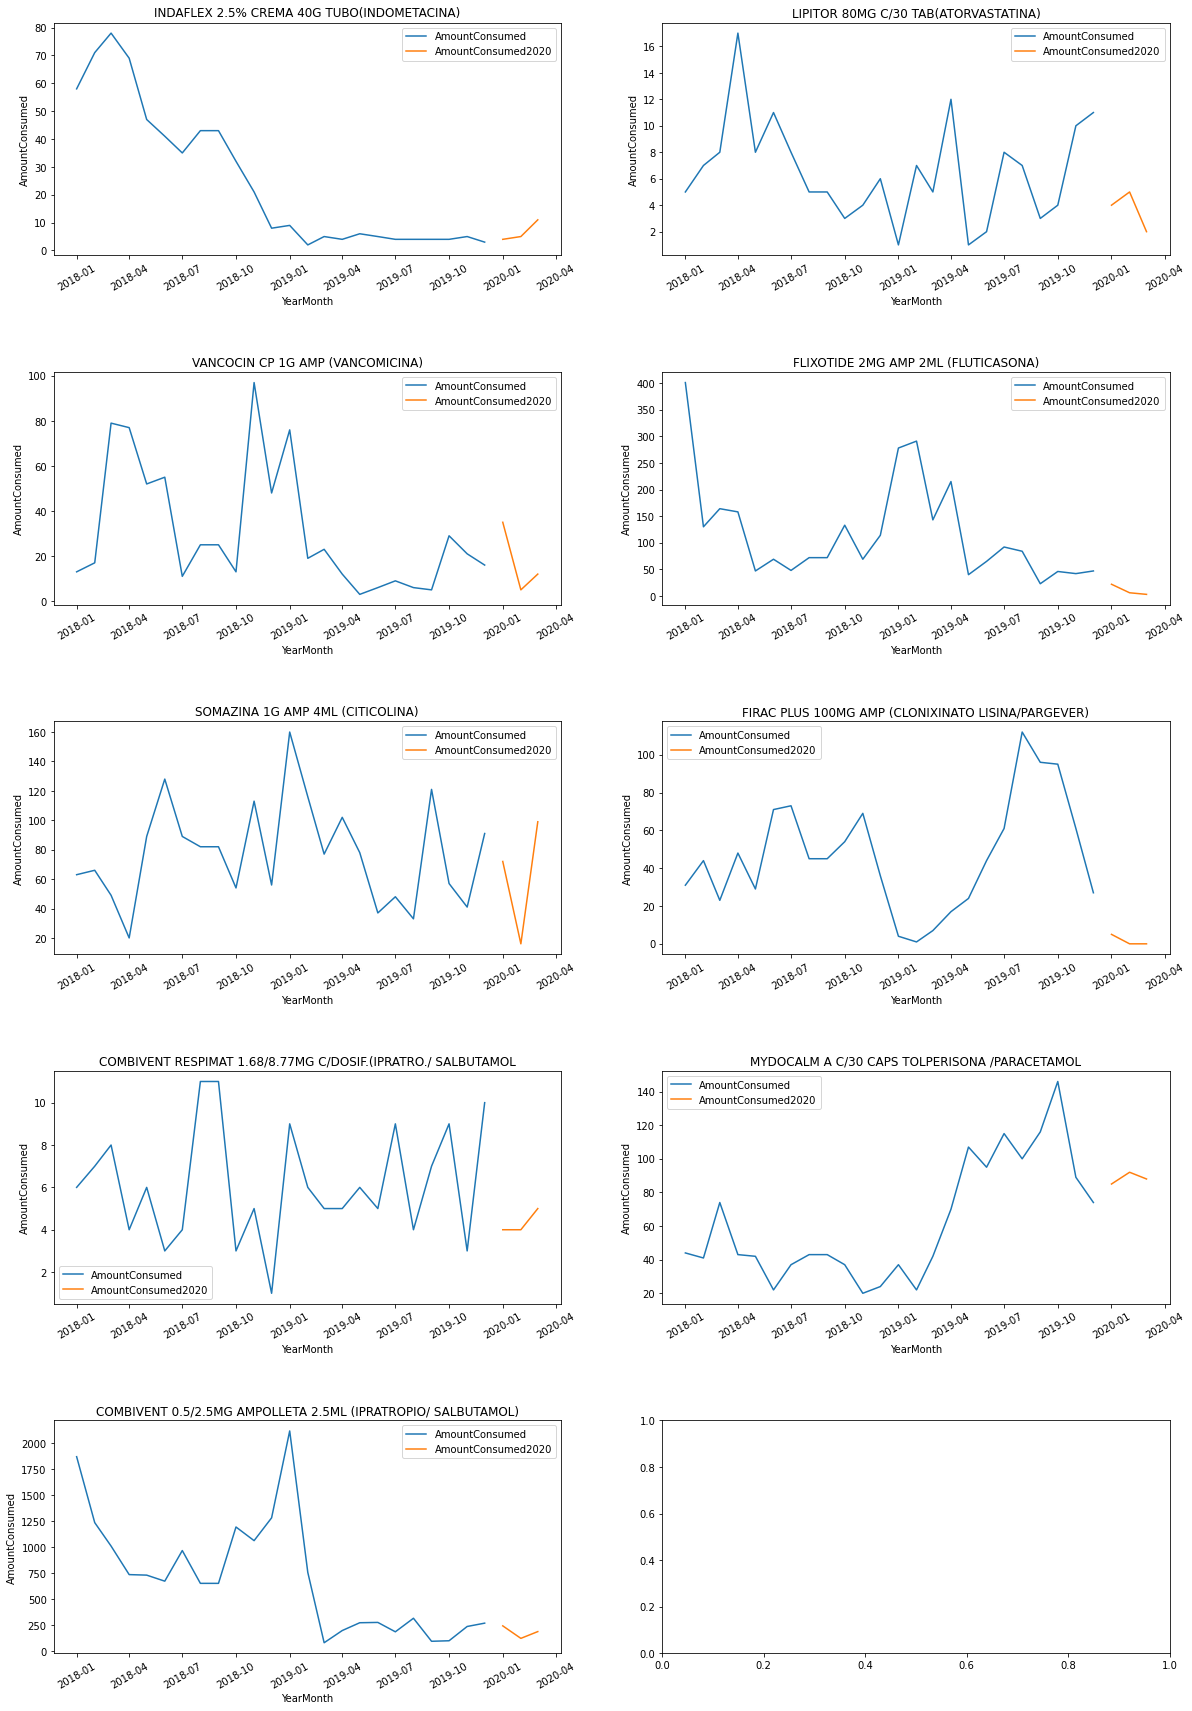

In [13]:
fig, axes = plt.subplots(5, 2, figsize=(20,30))
fig.subplots_adjust(hspace=0.5)
for ax, MedCode in zip(axes.flatten(), TopMedCodes):
    MedDescription = PatentDrugs[PatentDrugs['MedCode']==MedCode]['MedDescription'].values[0]
    sns.lineplot(data=MonthlyMeds[MonthlyMeds["MedCode"]==MedCode], x='YearMonth', y='AmountConsumed', ax=ax)
    sns.lineplot(data=AmountConsumed2020[AmountConsumed2020["MedCode"]==MedCode], x='YearMonth', y='AmountConsumed', ax=ax)
    ax.legend(['AmountConsumed','AmountConsumed2020'])
    ax.tick_params('x', labelrotation=30)
    ax.set(title=MedDescription)

___
# Timeseries prediction

## Helper methods

We transform the test and train dataset 

In [15]:
# Normalize data from sorted pd.Series with MedCode as index
def normalize_data(data, x_length):
    medcode = []
    norm_data = []
    orig_data = {}
    mean = {}
    std  = {}

    for i, MedCode in enumerate(data.index.unique()):
        medcode.append(MedCode)
        chunk = data[data.index==MedCode].values

        # first derivative to remove trends
        orig_data[MedCode] = chunk
        chunk = np.diff(chunk)
        # normalize using x split stats
        mean[MedCode] = chunk[:x_length].mean()
        std[MedCode]  = chunk[:x_length].std()
        chunk = (chunk - mean[MedCode]) / std[MedCode]

        chunk.reshape(len(chunk),1)
        norm_data.append(chunk)

    return {'medcode'   : medcode,
            'norm_data' : np.array(norm_data),
            'orig_data' : orig_data,
            'mean'      : mean,
            'std'       : std}

# Plot train history
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title(title)
    plt.legend()
    return plt

# Show prediction plot
def show_plot(plot_data, title):
    plt.plot(range(-len(plot_data[0]),0), plot_data[0], '.-')
    plt.plot(plot_data[1], 'bx-')
    plt.plot(plot_data[2], 'g.-')
    plt.title(MedDescription)
    plt.legend(['History', 'True Future', 'Model Prediction'])
    return plt

# Compute antiderivative of timeseries
def integrate(diff_data, y0):
    int_data = [y0]
    for i in range(len(diff_data)):
        int_data.append(int_data[i]+diff_data[i])
    return int_data

We count how many months of data every medcode has. We need the same amount of attributes 24+3 variables to predict to fit the model. Data should follow same dimension for a RNN. LSTM specifically. Because of its architecture, it a RNN specifically used for forecast because it has the characteristic to be able to weight  and balance attributes that are most inmmediate, like Nov, Dec 2019, and also older. It can help accomplish balance.

87 medications were consumed uninterruptedly from January 2018 to December 2019.

(87,)


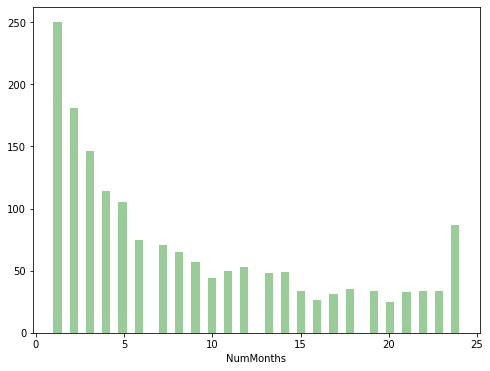

In [16]:
# Number of months per MedCode

NumMonths     = MonthlyMeds.groupby(['MedCode','YearMonth']).count().reset_index().groupby('MedCode').count().sort_values('YearMonth', ascending=False)
NumMonths24   = NumMonths[NumMonths['YearMonth']==24].index.values
print(NumMonths24.shape)

NumMonths = NumMonths['YearMonth'].rename('NumMonths')
plt.figure(figsize=(8,6))
sns.distplot(NumMonths, bins=50, color='g', kde=False);

In [17]:
# diferentiate and normalize univariate data from pd.Series

x_length = 24 # train on 24, predict 3
y_length = 3

xConsumed24 = MonthlyMeds[(MonthlyMeds['MedCode'].isin(NumMonths24))]
yConsumed24 = AmountConsumed2020[(AmountConsumed2020['MedCode'].isin(NumMonths24))]
MedSeries27 = pd.concat([xConsumed24[['YearMonth','MedCode','AmountConsumed','MedDescription']], yConsumed24], ignore_index=True)
MedSeries27 = MedSeries27.sort_values(['MedCode','YearMonth'])

# Normalize train split
train_data = MedSeries27[~MedSeries27['MedCode'].isin(TopMedCodes)].set_index('MedCode')['AmountConsumed']
train_data = normalize_data(train_data, x_length)
# Normalize test split
test_data = MedSeries27[MedSeries27['MedCode'].isin(TopMedCodes)].set_index('MedCode')['AmountConsumed']
test_data = normalize_data(test_data, x_length)

print(train_data['norm_data'].shape, test_data['norm_data'].shape)

(78, 26) (9, 26)


**2 types of transformations**

Differentiation. To remove trends, to flatten the time series, make it more lineal.

Normalization. Substract the mean of the timeseries divided by standard deviation before being fed to the model.

/home/jovyan/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jovyan/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


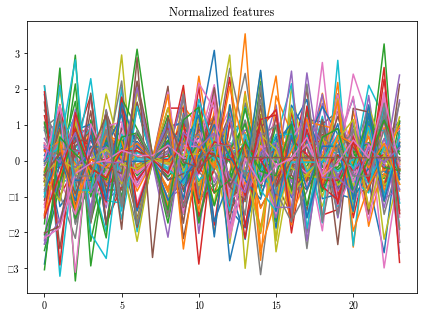

In [21]:
plt.figure(figsize=(7,5))
for i in range(train_data['norm_data'].shape[0]):
    sns.lineplot(data=train_data['norm_data'][i][:x_length]).set(title='Normalized features');

___
# Single step forecast

It predicts only one month ahead, and it has better accuracy.

In [19]:
# train & validation splits

x = []
y = []
x_length = train_data['norm_data'].shape[1]-y_length

for Med in range(train_data['norm_data'].shape[0]):
    x.append(train_data['norm_data'][Med][:-y_length].reshape(x_length,1))
    y.append(train_data['norm_data'][Med][-y_length])

x_train,x_val,y_train,y_val = train_test_split(x, y, test_size=0.1, random_state=42)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

BATCH_SIZE = 1 # Stochastic Gradient Descent
BUFFER_SIZE = 1

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val = val.batch(BATCH_SIZE).repeat()

(70, 23, 1) (70,)
(8, 23, 1) (8,)


Epoch 1/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.5951 - val_loss: 0.2801
Epoch 2/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3680 - val_loss: 0.2557
Epoch 3/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3567 - val_loss: 0.3654
Epoch 4/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3190 - val_loss: 0.2194
Epoch 5/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3219 - val_loss: 0.2382
Epoch 6/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3335 - val_loss: 0.1600
Epoch 7/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2988 - val_loss: 0.2430
Epoch 8/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3100 - val_loss: 0.1906
Epoch 9/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3055 - val_loss: 0.1145
Epoch 10/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.301

<module 'matplotlib.pyplot' from '/home/jovyan/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

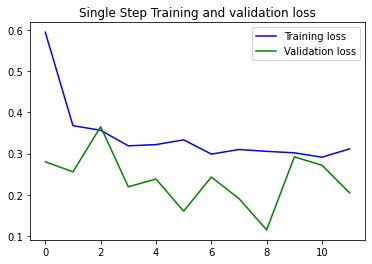

In [20]:
# define model
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(16, input_shape=x_train.shape[-2:]),
        tf.keras.layers.Dropout(rate=0.5),    
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(1)
    ])
model.compile(optimizer='adam', loss='mae')

# train model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
EPOCHS = 20
EVALUATION_INTERVAL = 1000

model_hist = model.fit(train,
                       epochs=EPOCHS,
                       steps_per_epoch=EVALUATION_INTERVAL,
                       validation_data=val,
                       validation_steps=50,
                       callbacks=[callback])

plot_train_history(model_hist, 'Single Step Training and validation loss')

Although validation loss is oscillating, we appreciate an trend decrease in loss for both, which makes it valuable.

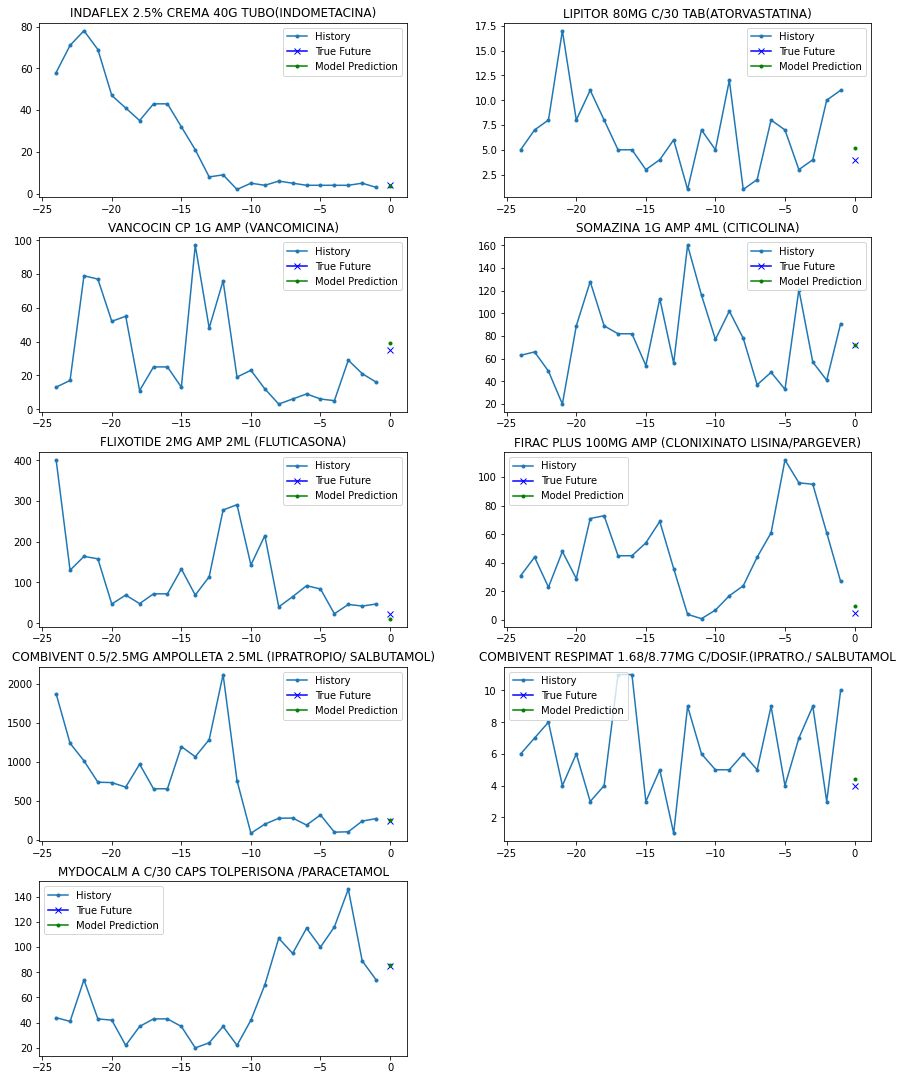

In [21]:
# plot predictions on test split

y_length = 1 # predict only one month
x_length  = x_train.shape[-2]
test_size = test_data['norm_data'].shape[0]
loss = []
pred = []
plt.figure(figsize=(13,15))

for i, MedCode in enumerate(test_data['medcode']):
        
    x = np.array(test_data['norm_data'][i][:x_length])
    y = np.array(test_data['norm_data'][i][-y_length])
    
    orig_data = test_data['orig_data'][MedCode]
    mean      = test_data['mean'][MedCode]
    std       = test_data['std'][MedCode]
    
    # predict
    diff_pred = model.predict(x.reshape(1, x_length, 1))
    
    # integrate prediction
    diff_pred = np.concatenate((x, diff_pred), axis=None)*std+mean
    int_pred = np.array(integrate(diff_pred, orig_data[0])) # inititialize with y0
    int_pred[int_pred<0]=0 # truncate negative values
    pred.append(int_pred[-1])
    loss.append(np.mean(np.abs(orig_data[-3]-int_pred[-1])))
    
    # de-normalize
    plot_data = [orig_data[:-3], orig_data[-3], int_pred[-1]]
    
    # show prediction
    MedDescription = PatentDrugs[PatentDrugs['MedCode']==MedCode]['MedDescription'].values[0]
    plt.subplot(np.ceil(test_size/2), 2, i+1)
    show_plot(plot_data, MedDescription)
    
plt.tight_layout(pad=0.7)
plt.show()

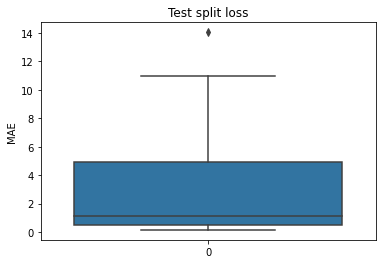

Average MAE: 4.0904


In [22]:
# plot loss
sns.boxplot(data=loss).set(title='Test split loss', ylabel='MAE')
plt.show();
print('Average MAE: %.4f' % np.mean(loss))
# Best iteration Average MAE: 4.0904

In the original scale, when predicting one month in the future, it would a mean average error of 4 "boxes" of a medicine for the 9 drugs. 

___
# Multi-step forecast

Y labels shape changes to 3 to predict three months ahead.

In [80]:
# train & validation splits

x = []
y = []
y_length = 3
x_length = train_data['norm_data'].shape[1]-y_length

for Med in range(train_data['norm_data'].shape[0]):
    x.append(train_data['norm_data'][Med][:-y_length].reshape(x_length,1))
    y.append(train_data['norm_data'][Med][-y_length:].reshape(y_length,))

x_train,x_val,y_train,y_val = train_test_split(x, y, test_size=0.1, random_state=42)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

BATCH_SIZE = 1 # Stochastic Gradient Descent
BUFFER_SIZE = 1

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val = val.batch(BATCH_SIZE).repeat()

(70, 23, 1) (70, 3)
(8, 23, 1) (8, 3)


Epoch 1/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6965 - val_loss: 0.5817
Epoch 2/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.5662 - val_loss: 0.6175
Epoch 3/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4868 - val_loss: 0.5006
Epoch 4/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4636 - val_loss: 0.4882
Epoch 5/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4517 - val_loss: 0.5007
Epoch 6/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4396 - val_loss: 0.5280
Epoch 7/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4267 - val_loss: 0.4801
Epoch 8/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3982 - val_loss: 0.4518
Epoch 9/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3764 - val_loss: 0.4314
Epoch 10/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.362

<module 'matplotlib.pyplot' from '/home/jovyan/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

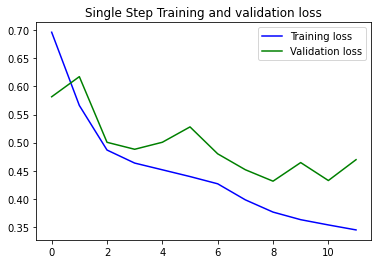

In [81]:
# define model
'''
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(16, input_shape=x_train.shape[-2:]),
        #tf.keras.layers.Dense(units = x_train.shape[-2]//2, activation='relu'),
        #tf.keras.layers.Dense(units = x_train.shape[-2]//4, activation='relu'),
        #tf.keras.layers.Dropout(rate=0.25),
        tf.keras.layers.Dense(3)
    ])
model.compile(optimizer='adam', loss='mae')
'''
N_INPUTS = x_train.shape[-2]
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(16, input_shape=x_train.shape[-2:]))
model.add(tf.keras.layers.Dense((N_INPUTS // 2) // 2, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(3, activation = None))
model.compile(optimizer='adam', loss='mae')

# train model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
EPOCHS = 20
EVALUATION_INTERVAL = 1000

model_hist = model.fit(train,
                       epochs=EPOCHS,
                       steps_per_epoch=EVALUATION_INTERVAL,
                       validation_data=val,
                       validation_steps=50,
                       callbacks=[callback])

plot_train_history(model_hist, 'Single Step Training and validation loss')

Validation loss does not show overfitting over training epochs.

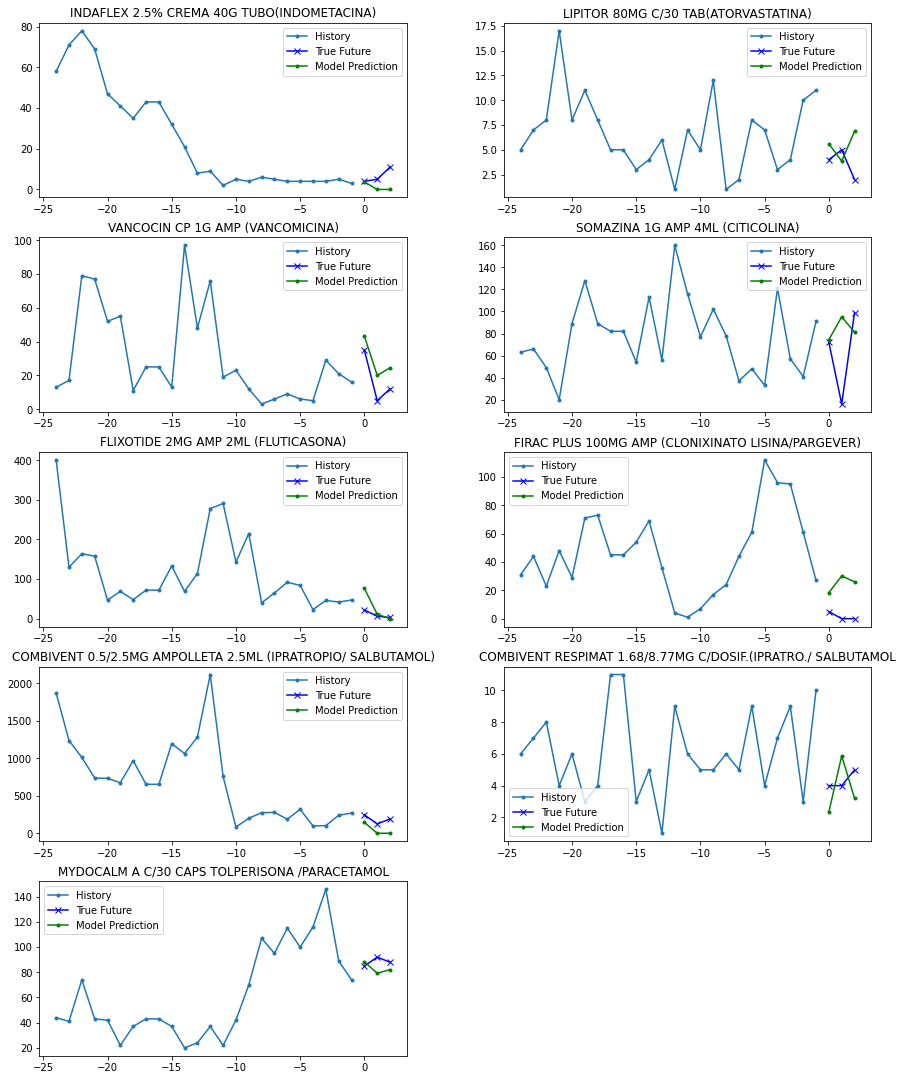

In [82]:
# plot predictions on test split

test_size = test_data['norm_data'].shape[0]
x_length  = test_data['norm_data'].shape[1]-y_length
loss = []
pred = []
df_all = pd.DataFrame()
plt.figure(figsize=(13,15))

for i, MedCode in enumerate(test_data['medcode']):
    
    x = np.array(test_data['norm_data'][i][:-y_length])
    y = np.array(test_data['norm_data'][i][-y_length:])
    orig_data = test_data['orig_data'][MedCode]
    mean      = test_data['mean'][MedCode]
    std       = test_data['std'][MedCode]
    
    # predict
    diff_pred = model.predict(x.reshape(1, x_length, 1))
    
    # integrate prediction
    diff_pred = np.concatenate((x, diff_pred), axis=None)*std+mean
    int_pred = np.array(integrate(diff_pred, orig_data[0]))
    int_pred[int_pred<0]=0 # truncate negative values
    pred.append(int_pred[-y_length:])
    loss.append(np.mean(np.abs(orig_data[-y_length:]-int_pred[-y_length:])))
    
    # de-normalize
    plot_data = [orig_data[:-y_length], orig_data[-y_length:], int_pred[-y_length:]]
    
    # show prediction
    MedDescription = PatentDrugs[PatentDrugs['MedCode']==MedCode]['MedDescription'].values[0]
    plt.subplot(np.ceil(test_size/2), 2, i+1)
    plot = show_plot(plot_data, MedDescription)
    
    #plt.plot(int_pred, 'b-')
    #plt.plot(orig_data, 'g-')
    #plt.legend(['pred','true'])
    #plt.title(MedDescription);
    
    df = pd.DataFrame()
    df['Month'] = pd.date_range(start='31/1/2018', periods=27, freq='M')
    df['MedCode'] = int(MedCode)
    df['AmountConsumed'] = orig_data
    df['Forecast'] = int_pred
    df_all = pd.concat([df_all,df])
    
df_all.to_csv('forecasts/NeuralNetForecast2020.csv', index=False)
plt.tight_layout(pad=0.7)
plt.show()

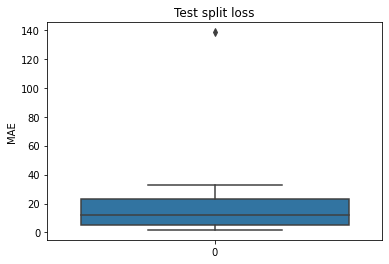

Average MAE: 27.1634


In [83]:
# plot loss
sns.boxplot(data=loss).set(title='Test split loss', ylabel='MAE')
plt.show();
print('Average MAE: %.4f' % np.mean(loss))
# Best iteration Average MAE: 17.3191

The error clearly increases when predicting more than one month ahead.